# 2. 프로젝트: ResNet Ablation Study

ResNet-34, ResNet-50 네트워크를 직접 만들어보자.   
ResNet은 residual connection을 활용해서 깊은 네트워크를 쌓았을 때, 이를 통한 성능 향상을 증명하고 있다. 직접 구현해보고 차이가 있는지 살펴보자.

In [165]:
! 

In [166]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [167]:
# tf GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1) CIFAR-10 데이터셋 준비하기
구현한 ResNet 모델과 Plain 모델을 비교하기 위해 CIFAR-10 데이터셋을 준비하자.

In [168]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # download bar disable

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0R4UI1/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete0R4UI1/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [169]:
# feature 정보 확인
# tensorflow의 데이터셋은 shape가 불가능하다. 그래서 info를 사용해서 확인하자.
print(ds_info.features)

# 데이터의 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### 2) 정규화
이미지의 픽셀 값을 0~1 사이로 만들기 위해 정규화를 진행하자.   
이는 상대적으로 scale이 큰 feaures의 영향을 줄이고, local optimum에 빠질 위험도 줄인다.

In [170]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224]) # image resize
    return tf.cast(image, tf.float32) / 255., label

In [171]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 3) 데이터셋 확인하기
CIFAR-10은 10개의 클래스로 이루어진 데이터셋이다.   
클래스가 어떻게 이루어져있는지 확인해보자.

In [172]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


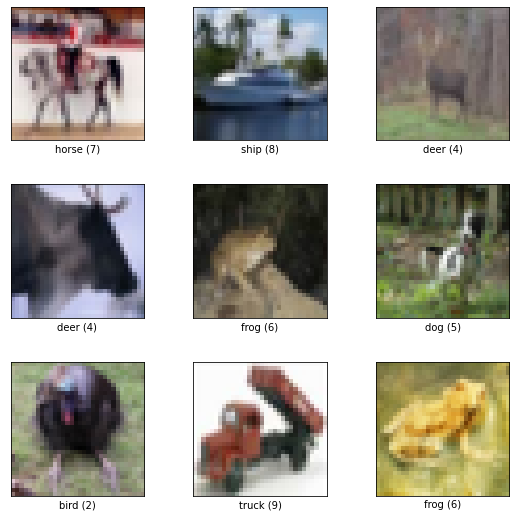

In [173]:
fig = tfds.show_examples(ds_train, ds_info)

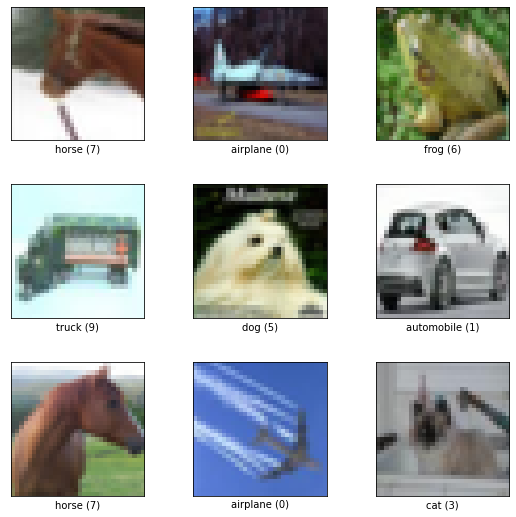

In [174]:
fig = tfds.show_examples(ds_test, ds_info)

# 2-1. ResNet 기본 블록 구성하기

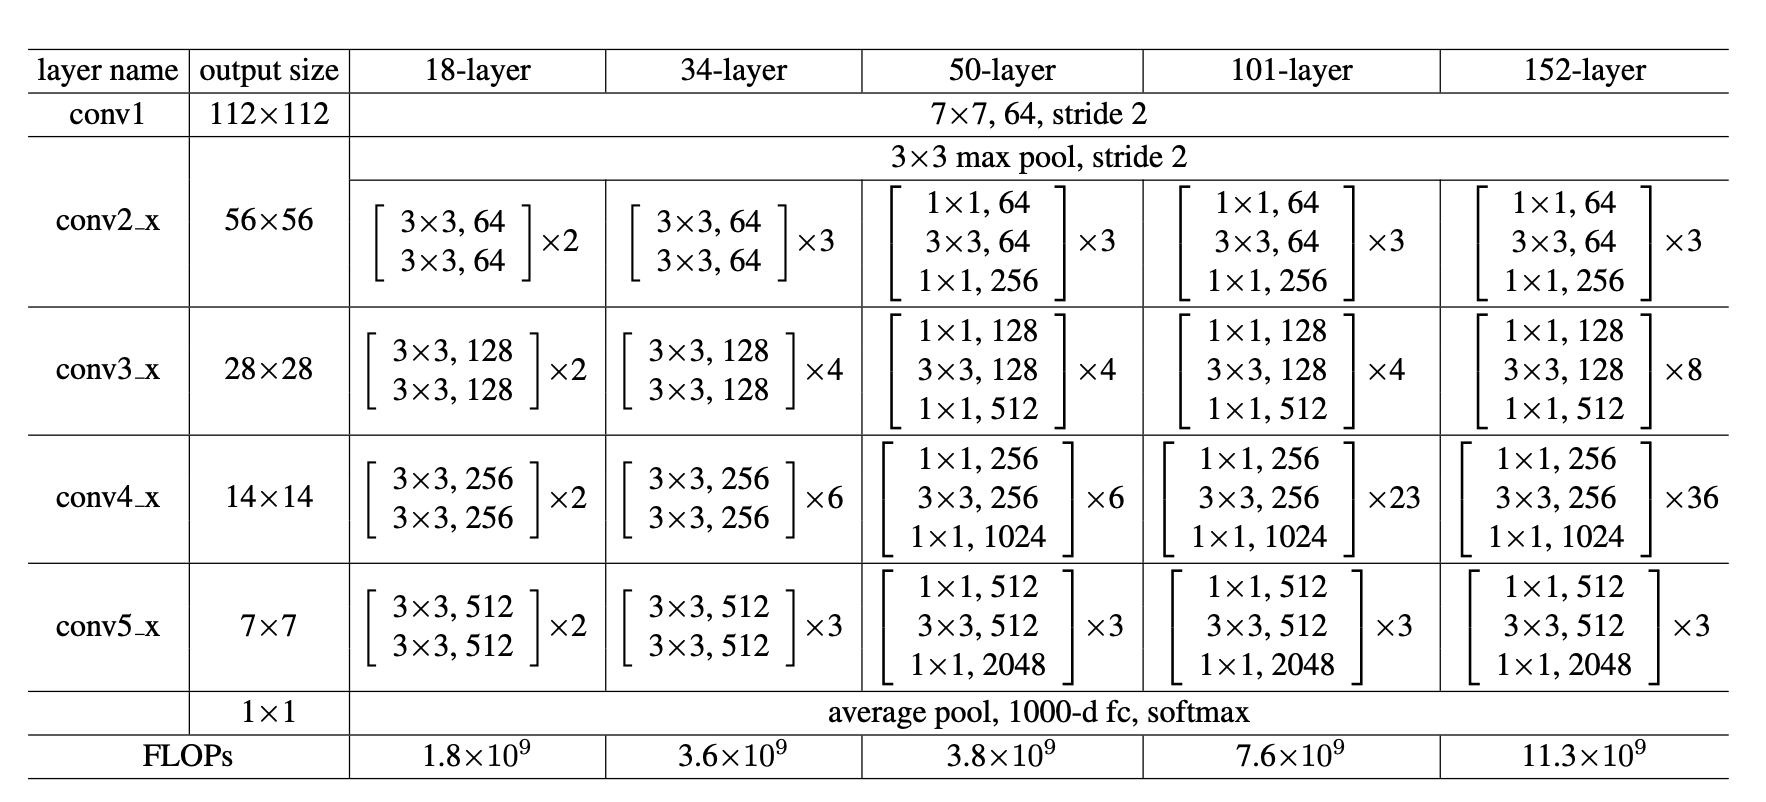

ResNet-34, ResNet-50 layer 구성요소의 기본 block을 만들자.

In [175]:
# def basic_resnet_block(input_layer,
#                        kernel_size=3,
#                        channel=64,
#                        num_cnn=3,
#                        layer_num=2,
#                        is_50=False):

#     x = input_layer
#     shortcut = x

#     if is_50 == False:
#         for i in range(num_cnn):
#             x = keras.layers.Conv2D(kernel_size=kernel_size,
#                                     channel=channel,
#                                     name=f'block{layer_num}_conv{i}')(x)
#             x = keras.layers.BatchNormalization()(x)
#             x = keras.layers.Activation('relu')(x)

#             x = keras.layers.Conv2D(kernel_size=kernel_size,
#                                     channel=channel,
#                                     name=f'block{layer_num}_conv{i}')(x)
#             x = keras.layers.BatchNormalization()(x)

#     elif is_50 == True:
#         for i in range(num_cnn):
#             x = keras.layers.Conv2D(kernel_size=1,
#                                     channel=channel,
#                                     name=f'block{layer_num}_conv{i}')(x)
#             x = keras.layers.BatchNormalization()(x)
#             x = keras.layers.Activation('relu')(x)

#             x = keras.layers.Conv2D(kernel_size=kernel_size,
#                                     channel=channel,
#                                     name=f'block{layer_num}_conv{i}')(x)
#             x = keras.layers.BatchNormalization()(x)
#             x = keras.layers.Activation('relu')(x)

#             x = keras.layers.Conv2D(kernel_size=1,
#                                     channel=channel*4,
#                                     name=f'block{layer_num}_conv{i}')(x)
#             x = keras.layers.BatchNormalization()(x)

#     # add shortcut(skip connection)
#     x = keras.layers.Add()([x,shortcut])
#     x = keras.layers.Activation('relu')(x)

#     return x

In [176]:
# def build_resnet_block(input_shape=(32,32,3),
#                        is_50=False, # is_50은 resnet layer 34, 50 flag
#                        num_classes=10): 

#     num_cnn_list=[3,4,6,3]
#     channel_list=[64,128,256,512]
    
#     input_layer = keras.layers.Input(shape=input_shape)
#     output = input_layer
    
#     # conv1
#     output = keras.layers.Conv2D(kernel_size=7,
#                                  channel=64,
#                                  strides=2,
#                                  name='conv1')(output)
#     output = keras.layers.BatchNormalization()(output)
#     output = keras.layers.Activation('relu')(output)

#     # conv2
#     output = tf.keras.layers.MaxPooling2D(pool_size=3,
#                                           strides=2,
#                                           name='conv2_MaxPooling')(output)
    
#     for i, num_cnn in enumerate(num_cnn_list):
#         layer_num=i+2
#         output = basic_resnet_block(input_layer=output,
#                                     kernel_size=3,
#                                     channel=channel_list[i], # 64,128,256,512
#                                     num_cnn=num_cnn, # 3,4,6,3
#                                     layer_num=layer_num,
#                                     is_50=False) # 2,3,4,5
    

#     output = keras.layers.AveragePooling2D()(output)
#     output = keras.layers.Dense(10, activation=softmax)(output)


#     if is_50==True:
#         model = keras.Model(inputs=input_layer,outputs=output, name='ResNet50')
#     else:
#         model = keras.Model(inputs=input_layer,outputs=output, name='ResNet34')

#     return model

In [177]:
# resnet_50 = build_resnet_block(input_shape=(32,32,3), is_50=False)  
# resnet_50.summary()

# 2-2. 일반 네트워크(plain network) 만들기

# 2-3. ResNet-50 vs Plain-50, ResNet-34 vs Plain-34

---

In [178]:
def basic_resnet_block(input_layer,
                       channel=64,
                       kernel_size=3,
                       strides=2,
                       activation='relu',
                       layer_count=2,
                       cnn_count=3,
                       is_50=False):

    x = input_layer
    shortcut = x

    x = keras.layers.Conv2D(channel, kernel_size, strides)(x)

    return x

In [183]:
def build_resnet(input_shape=(32,32,3), is_50=True, num_classes=10):
    num_cnn_list=[3,4,6,3]
    channel_list=[64,128,256,512]

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    output = basic_resnet_block(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    

    model = keras.Model(inputs=input_layer, outputs=output)

In [186]:
test = build_resnet()
test.summary()

AttributeError: ignored